In [1]:
#!/usr/bin/env python2
import os
import sys
import argparse
import time
from distutils.dir_util import copy_tree

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import binary_crossentropy

from iterator import Iterator
import autoencoder_model as ae_model
import models_v4 as gan_model

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline


_FLOATX = config.floatX


Using gpu device 0: Quadro K6000 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/u/larocste/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [40]:
#Training hyper-parameters

weight_decay = 0
num_epochs = 500
max_patience = 100
SAVEPATH = 'save_models' 
LOADPATH = 'load_models'
batch_size = 400
extract_center = True
load_caption = True
#nb_discriminator_steps = 2

#Model Hyperparameters
conv_before_pool=[2,2]
n_filters = 32                      
code_size = 750
filter_size = 3
pool_factor = 2
output_nonlin = lasagne.nonlinearities.tanh

all_caps = True

learning_rate_gen = 0.05
learning_rate_discr = 0.05
lambda_rec = 1.0
lambda_adv = 0.5#.05
clip_treshold = 0.05


subset_train = 5
subset_valid = 5

In [3]:
#######################
# Saving path and stuff
######################

exp_name = 'nb_AEwgan_'+ ('5' if all_caps else '1') + 'caps'
#exp_name += '_nonlin='+str(output_nonlinD)
exp_name += '_lrG='+str(learning_rate_gen)
exp_name += '_lrD='+str(learning_rate_discr)
exp_name += '_lambREC=' +str(lambda_rec)
exp_name += '_lambADV='+str(lambda_adv)
exp_name += '_clip='+str(clip_treshold)
exp_name += '_wd='+str(weight_decay)
exp_name += '_bs='+str(batch_size)
exp_name += '_conv='+str(conv_before_pool)
exp_name += '_nfilt='+str(n_filters)
exp_name += '_code='+str(code_size)
exp_name += ('_subTRAIN'+str(subset_train)) if subset_train>0 else ''
exp_name += ('_subVALID'+str(subset_valid)) if subset_valid>0 else ''




savepath=os.path.join(sys.path[1],SAVEPATH, exp_name)
loadpath=os.path.join(sys.path[1],LOADPATH, exp_name)

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))
print 'Saving directory : ' + savepath
print 'Loading directory : '+ loadpath

 The following folder already exists /u/larocste/ift6266_project/save_models/nb_AEwgan_5caps_lrG=0.01_lrD=0.0005_lambREC=1.0_lambADV=0.5_clip=0.05_wd=0_bs=400_conv=[2, 2]_nfilt=32_code=750_subTRAIN1_subVALID5. It will be overwritten in a few seconds...
Saving directory : /u/larocste/ift6266_project/save_models/nb_AEwgan_5caps_lrG=0.01_lrD=0.0005_lambREC=1.0_lambADV=0.5_clip=0.05_wd=0_bs=400_conv=[2, 2]_nfilt=32_code=750_subTRAIN1_subVALID5
Loading directory : /u/larocste/ift6266_project/load_models/nb_AEwgan_5caps_lrG=0.01_lrD=0.0005_lambREC=1.0_lambADV=0.5_clip=0.05_wd=0_bs=400_conv=[2, 2]_nfilt=32_code=750_subTRAIN1_subVALID5


In [4]:
#######################
#Build dataset iterator
#######################

print "Loading training data..." #threads???
train_iter = Iterator(which_set='train', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

print "Loading validation data..." #threads???
valid_iter = Iterator(which_set='valid', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

test_iter = None

vocab_size = len(train_iter.vocab)
print 'Vocabulary size : ', vocab_size

n_batches_train = train_iter.n_batches
n_batches_valid = valid_iter.n_batches
n_batches_test = test_iter.n_batches if test_iter is not None else 0

print "Batch. train: %d, val %d, test %d" % (n_batches_train,
                            n_batches_valid, n_batches_test)

Loading training data...
Loading the captions...
Done
We have a vocabulary of size 7574
processing the text...
Done
Loading validation data...
Loading the captions...
Done
We have a vocabulary of size 7574
processing the text...
Done
Vocabulary size :  7574
Batch. train: 206, val 101, test 0


In [8]:
##########################################
# Build generator and discriminator models
##########################################
print('Defining symbolic variables and building models')

#Input and target var for the generator
ae_input_var = T.tensor4('input img bx3x32x32')
ae_captions_var = T.matrix('captions var')


model = ae_model.AE_contour2center_captions()

model.build_network(input_var = ae_input_var,
                  captions_var = ae_captions_var,
                  conv_before_pool=conv_before_pool,
                  output_nonlin = lasagne.nonlinearities.sigmoid,
                  n_filters = n_filters,
                  code_size = code_size,
                  filter_size = filter_size,
                  pool_factor = pool_factor)


Defining symbolic variables and building models


In [9]:
ae_target_var = T.tensor4('target var bx3x32x32')

D = gan_model.discriminator()
D.build_network(input_var = ae_target_var, contour_var = ae_input_var, conv_before_pool = [1,1,1,1])

D_over_G = gan_model.discriminator_over_generator()
D_over_G.build_network(G_net = model, D_net=D)

In [10]:
model.compile_theano_functions(learning_rate= learning_rate_gen, comp_train = False, comp_valid=False)

Defining and compiling get_imgs function
Done


In [41]:
#####################################
# Define and compile theano functions
#####################################

print "Defining and compiling theano functions"

pred_img = lasagne.layers.get_output(model.net)
rec_loss = model.get_loss(pred_img, ae_target_var)


D_predictions = lasagne.layers.get_output(D.net)
D_over_G_predictions = lasagne.layers.get_output(D_over_G.net)





print 'model.train_fn'

model_loss = lambda_rec*rec_loss - lambda_adv*T.mean(D_over_G_predictions)

ae_params = lasagne.layers.get_all_params(model.net, trainable=True)
ae_updates = lasagne.updates.adam(model_loss, ae_params, learning_rate = learning_rate_gen)
model.train_fn = theano.function([ae_input_var,ae_captions_var, ae_target_var], model_loss, updates = ae_updates,
                            allow_input_downcast=True)


print 'D.train_fn'

D_loss = -0.5*T.mean(D_predictions - D_over_G_predictions)
D_params = lasagne.layers.get_all_params(D.net, trainable=True)
D_updates = lasagne.updates.adam(D_loss, D_params, learning_rate=learning_rate_discr)
D.train_fn = theano.function([ae_input_var, ae_captions_var, ae_target_var], D_loss, updates=D_updates,
                            allow_input_downcast=True, on_unused_input='ignore')

print 'Done'



Defining and compiling theano functions
model.train_fn
D.train_fn
Done


In [12]:
valid_pred_imgs = lasagne.layers.get_output(model.net,deterministic=True)
valid_loss = lambda_rec*model.get_loss(valid_pred_imgs, ae_target_var) - lambda_adv*T.mean(lasagne.layers.get_output(D_over_G.net))

valid_fn = theano.function([ae_input_var,ae_captions_var, ae_target_var], valid_loss, allow_input_downcast=True)
model.valid_fn = valid_fn

In [13]:
D.get_pred = theano.function([ae_input_var, ae_captions_var, ae_target_var], D_predictions, on_unused_input='ignore')
D_over_G.get_pred = theano.function([ae_input_var, ae_captions_var, ae_target_var], D_over_G_predictions, on_unused_input='ignore')

In [14]:
plot_results_train = True
plot_results_valid = True


num_epochs = 50


In [15]:
# Initialization

err_train = []
err_D_train = []
err_valid = []

patience = 10

reset_best_results = True

Start training


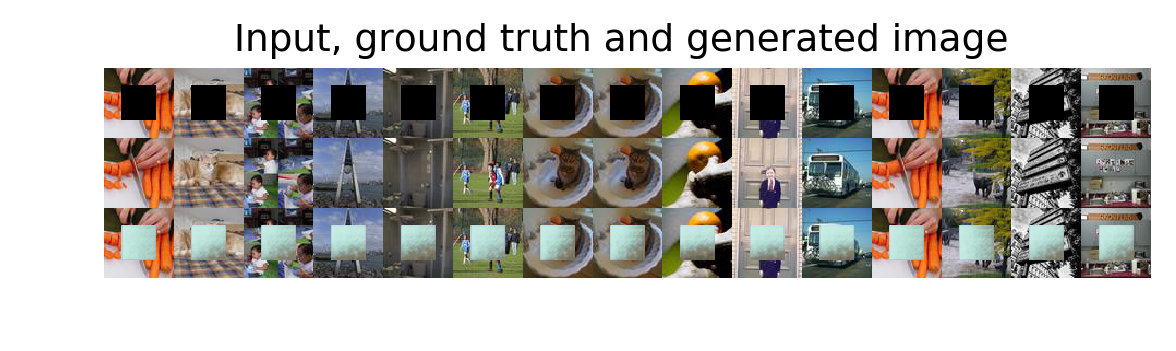

EPOCH 0: Avg cost train 0.000271, cost discr train 0.000217, cost val 0.000000, took 24.760075 s


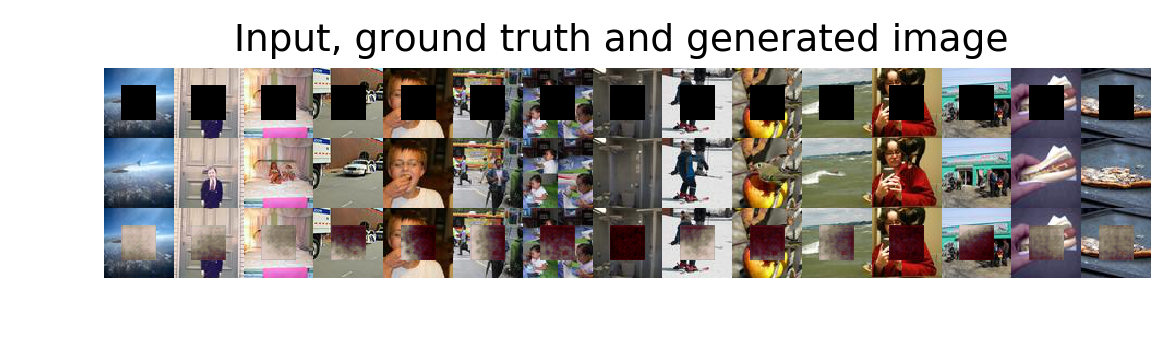

EPOCH 1: Avg cost train -0.001895, cost discr train 0.000794, cost val 0.000000, took 23.656851 s


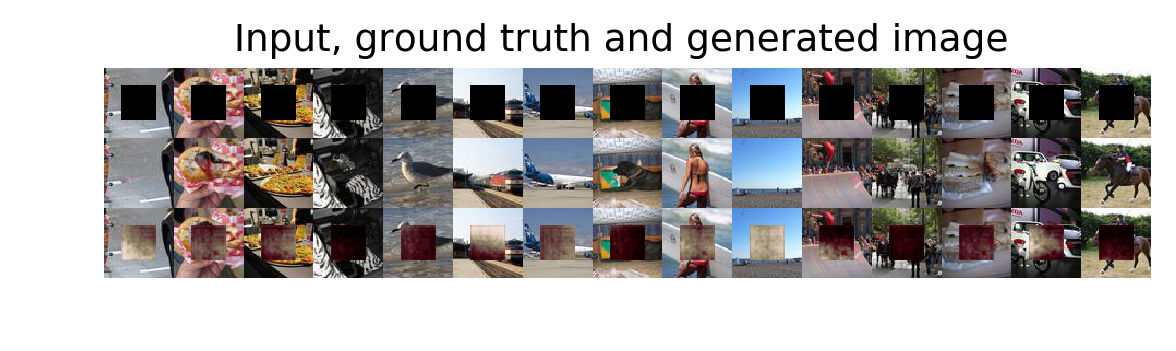

EPOCH 2: Avg cost train -0.001968, cost discr train -0.000039, cost val 0.000000, took 26.736099 s


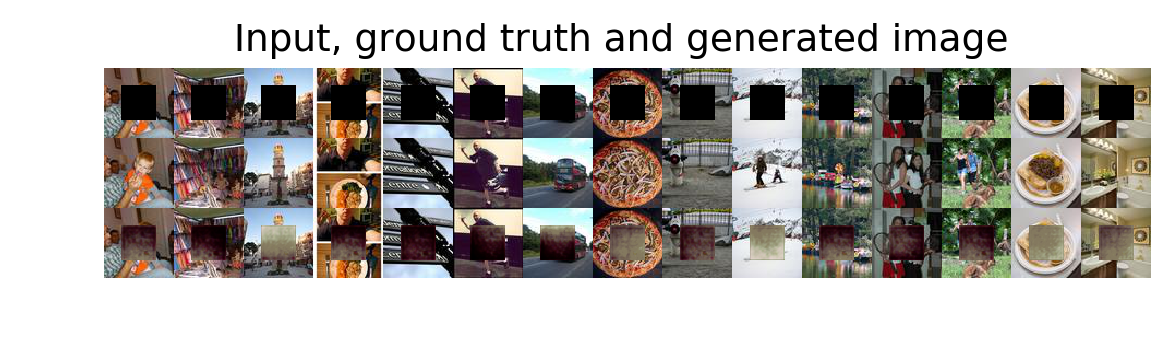

EPOCH 3: Avg cost train -0.002058, cost discr train -0.000004, cost val 0.000000, took 22.037740 s


KeyboardInterrupt: 

In [42]:
#
# Train loop
#



# Training main loop
print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))
    
    start_time = time.time()
    cost_train_epoch = 0
    cost_D_epoch = 0
    
    # Train      
        
    for i, train_batch in enumerate(train_iter):
        
        if subset_train > 0 and i>= subset_train:#n_batches_train:
            break
          
        train_batch = model.extract_batch(train_batch)
        inputs_train, targets_train, caps_train = train_batch
        
 
    
        
        cost_D_batch = D.train_fn(inputs_train, caps_train, targets_train)
        cost_D_epoch += cost_D_batch  
        
        #print 'D pred', D.get_pred(inputs_train, caps_train, targets_train)[:10]
        #print 'DG pred ', D_over_G.get_pred(inputs_train, caps_train, targets_train)[:10]
        #print 'D cost batch', i, cost_D_batch
        
        
        clip_treshold = 0.05
        all_params = lasagne.layers.get_all_param_values(D.net)
        n_params = len(all_params)
#         new_params = [[] for param in range(n_params)]
        new_params = np.array([np.clip(all_params[j], -clip_treshold, clip_treshold) for j in range(n_params)])
#         for j in range(n_params):
#             new_params[j] = np.array(np.clip(all_params[j], -clip_treshold, clip_treshold))

        lasagne.layers.set_all_param_values(D.net, new_params)
        
        
        
        
        cost_train_batch = model.train_fn(inputs_train, caps_train, targets_train)
        cost_train_epoch += cost_train_batch
        #print 'ae cost batch ' , cost_train_batch
        
        
        if i%5==0:
            if plot_results_train: #select random example from the last minibatch and plot it
                model.compute_and_plot_results(train_batch, title='')
#                 model.compute_and_plot_results((inputs_train[215:230], targets_train[215:230], caps_train[215:230]), 
#                                                title = '')
    
        
        
        
    #Add epoch results    
    err_train += [cost_train_epoch/n_batches_train]
    
    err_D_train += [cost_D_epoch/n_batches_train]
    
    

    # Validation
    cost_val_epoch = 0
    

#     for i, valid_batch in enumerate(valid_iter):
        
#         if subset_valid > 0 and i> subset_valid:
#             break
#         #rint 'valid', i

#         valid_batch = model.extract_batch(valid_batch)
#         inputs_valid, targets_valid, caps_valid = valid_batch

#         # Validation step
#         cost_val_batch = model.valid_fn(inputs_valid, caps_valid, targets_valid)
#         #print i, 'validation batch cost : ', cost_val_batch


#         #Update epoch results
#         cost_val_epoch += cost_val_batch
        
    
#     if plot_results_valid: #select random example from the last minibatch and plot it
#         model.compute_and_plot_results(valid_batch, title = 'VALID')
        
    #Add epoch results 
    err_valid += [cost_val_epoch/n_batches_valid]
    

    #Print results (once per epoch)
    out_str = "EPOCH %i: Avg cost train %f, cost discr train %f, cost val %f, took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         err_D_train[epoch],
                         err_valid[epoch],
                         time.time()-start_time)
    print out_str
   
    






- 0.001 with l_adv = 1
- 0.001 with l_adv = 5
- 0.0001 with l_adv = 5 .. no clipping
- added clipping to 0.1
- l_adv to 0.05
- remove clipping


- l_adv = 05, lr_dis = 0.0001, treshcol = 0.05
- lr_gen = 0.05

In [ ]:
#     Early stopping and saving stuff
    
    with open(os.path.join(savepath, "ae_output.log"), "a") as f:
        f.write(out_str + "\n")
        
    if epoch == 0 and reset_best_results:
        best_err_valid = err_valid[epoch]
    elif epoch > 1 and err_valid[epoch] < best_err_valid:
        print('saving best (and last) model')
        best_err_valid = err_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'ae_model_best.npz'),*lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_best.npz"), err_train=err_train, err_valid=err_valid)
        np.savez(os.path.join(savepath, 'ae_model_last.npz'), *lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"), err_train=err_train, err_valid=err_valid)
        
        np.savez(os.path.join(savepath, 'D_model_best.npz'),*lasagne.layers.get_all_param_values(D.net))
        np.savez(os.path.join(savepath, 'D_model_last.npz'), *lasagne.layers.get_all_param_values(D.net))
        
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'ae_model_last.npz'), *lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath, 'D_model_last.npz'), *lasagne.layers.get_all_param_values(D.net))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"), err_train=err_train, err_valid=err_valid)
        
    # Finish training if patience has expired or max nber of epochs reached
    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break 

In [52]:
savepath

'/u/larocste/ift6266_project/save_models/nb_AE_caps_adv_lr=0.01_wd=0_bs=400_conv=[2, 2]_nfilt=32_code=750'

In [53]:
np.savez(os.path.join(savepath, 'ae_model_best.npz'),*lasagne.layers.get_all_param_values(model.net))
np.savez(os.path.join(savepath , "ae_errors_best.npz"), err_train=err_train, err_valid=err_valid)
np.savez(os.path.join(savepath, 'ae_model_last.npz'), *lasagne.layers.get_all_param_values(model.net))
np.savez(os.path.join(savepath , "ae_errors_last.npz"), err_train=err_train, err_valid=err_valid)
np.savez(os.path.join(savepath, 'D_model_best.npz'),*lasagne.layers.get_all_param_values(D.net))
np.savez(os.path.join(savepath, 'D_model_last.npz'), *lasagne.layers.get_all_param_values(D.net))